<a href="https://colab.research.google.com/github/PabloParadaSouto/Automatica/blob/master/ACTOR-CRITIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
!apt install xvfb -y
!pip install pyvirtualdisplay
from pyvirtualdisplay import Display
from IPython import display

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,815 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

KeyboardInterrupt: 

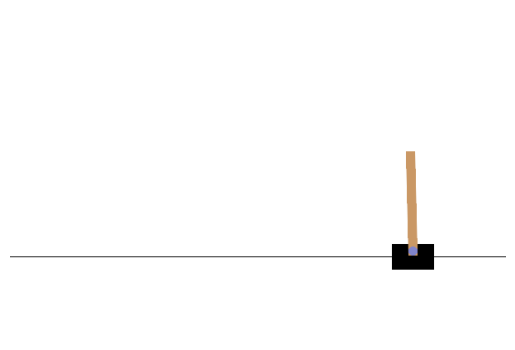

In [14]:
# Definir la red neuronal para el actor
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

# Definir la red neuronal para el crítico
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Implementar el algoritmo ACTOR-Critic
def actor_critic(env_name, max_episodes):
    d = Display()
    d.start()
    env = gym.make(env_name)
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    actor = Actor(input_dim, output_dim)
    critic = Critic(input_dim)
    actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
    critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

    for episode in range(max_episodes):
        print("EPISODIO: ", episode)
        state = env.reset()
        rewards = []
        log_probs = []

        while True:
            action_probs = actor(torch.FloatTensor(state))
            action = torch.multinomial(action_probs, 1).item()
            log_probs.append(torch.log(action_probs[action]))

            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)

            if done:
                Q_values = []
                Q_value = 0
                for r in rewards[::-1]:
                    Q_value = r + 0.99 * Q_value
                    Q_values.insert(0, Q_value)

                Q_values = torch.tensor(Q_values)
                log_probs = torch.stack(log_probs)
                values = critic(torch.FloatTensor(state))
                advantages = Q_values - values

                actor_loss = -torch.mean(log_probs * advantages.detach())
                critic_loss = torch.mean(advantages.pow(2))

                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                print(f"Actor output: {action_probs.detach().numpy().tolist()}")

                print(f"Critic output: {values.detach().numpy().tolist()}")

                print(f"Actor loss: {actor_loss.item()}")

                print(f"Critic loss: {critic_loss.item()}")

                break

            state = next_state
        print("\n")

        if episode>=850:
          img = plt.imshow(env.render('rgb_array'))

          display.clear_output(wait=True)
          img.set_data(env.render('rgb_array'))
          plt.axis('off')
          display.display(plt.gcf())


# Ejecutar el algoritmo
if __name__ == "__main__":
    actor_critic('CartPole-v1', max_episodes=1000)